In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

2022-04-22 18:04:59.643053: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 18:04:59.643072: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
company = 'FB'
start = dt.datetime(2012,1,1)
end = dt.date.today()
data = web.DataReader(company, 'yahoo', start, end)
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-04-14,214.990005,210.000000,214.889999,210.179993,18332700,210.179993
2022-04-18,213.380005,208.300003,210.000000,210.770004,16580800,210.770004
2022-04-19,218.429993,209.000000,210.520004,217.309998,20089900,217.309998
2022-04-20,214.160004,198.919998,213.610001,200.419998,43036500,200.419998
2022-04-21,202.970001,185.580002,201.600006,188.070007,49869400,188.070007


In [18]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [20]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
77/77 [==============================] - 7s 45ms/step - loss: 0.0116
Epoch 2/25
77/77 [==============================] - 3s 45ms/step - loss: 0.0028
Epoch 3/25
77/77 [==============================] - 3s 45ms/step - loss: 0.0024
Epoch 4/25
77/77 [==============================] - 3s 45ms/step - loss: 0.0024
Epoch 5/25
77/77 [==============================] - 3s 45ms/step - loss: 0.0024
Epoch 6/25
77/77 [==============================] - 3s 45ms/step - loss: 0.0020
Epoch 7/25
77/77 [==============================] - 4s 47ms/step - loss: 0.0019
Epoch 8/25
77/77 [==============================] - 4s 47ms/step - loss: 0.0021
Epoch 9/25
77/77 [==============================] - 4s 46ms/step - loss: 0.0020
Epoch 10/25
77/77 [==============================] - 4s 46ms/step - loss: 0.0017
Epoch 11/25
77/77 [==============================] - 4s 46ms/step - loss: 0.0019
Epoch 12/25
77/77 [==============================] - 4s 46ms/step - loss: 0.0016
Epoch 13/25
77/77 [==================

In [24]:
test_start = dt.datetime(2022,1,1)
test_end = dt.datetime.now()
test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'],test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

Text(0, 0.5, 'Share Price')

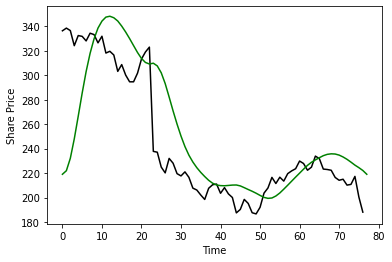

In [30]:
x_test = []
for x in range(prediction_days, len(model_inputs)+1):
    x_test.append(model_inputs[x-prediction_days:x,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

plt.plot(actual_prices, color="black")
plt.plot(predicted_prices, color="green")
plt.xlabel('Time')
plt.ylabel('Share Price')

In [37]:
real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
prediction

array([[219.03958]], dtype=float32)